In [1]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd

In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db
#Get the configuration file as a python dictionary
cfg = config()
try:
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [3]:
# is_fatal 
cursor.execute("SELECT status, retail_and_recreation_percentage,\
                   grocery_and_pharmacy_percentage, parks_percentage, transit_stations_percentage,\
                   workplaces_percentage, age_group, gender, phu_name, holiday, \
                   is_fatal from data_mart.fact_table as fact inner join data_mart.special_measures_dimension\
                   as measure on fact.special_measures_key = measure.special_measures_key \
                   inner join data_mart.patient_dimension as patient\
                   on fact.patient_key = patient.patient_key inner join data_mart.mobility_dimension as mobile\
                   on fact.mobility_key = mobile.mobility_key\
                   inner join data_mart.phu_location_dimension as phu\
                   on fact.phu_location_key = phu.phu_location_key\
                   inner join data_mart.test_date_dimension as test_date\
                   on fact.test_date_key = test_date.test_date_key;"
                  )

#Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
result_list = cursor.fetchall()

In [4]:
result_df = pd.DataFrame(result_list, columns=["status","retail_rec", "grocery_pharm", 
                                               "parks", "transit","workplaces","age_group",
                                               "gender","phu_name","holiday","is_fatal"])



In [5]:
result_df.head()

,status,retail_rec,grocery_pharm,parks,transit,workplaces,age_group,gender,phu_name,holiday,is_fatal
0,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,40s,MALE,Peel Public Health,False,False
1,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,50s,MALE,Peel Public Health,False,False
2,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,<20,MALE,Peel Public Health,False,False
3,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,30s,MALE,Peel Public Health,False,False
4,Private gathering restrictions,-11.0,4.0,NaN,-52.0,-50.0,20s,MALE,York Region Public Health Services,False,False


In [6]:
cursor.close()
conn.close()

In [7]:
#Remove null values - first check which columns have null values
result_df['status'].isna().sum() 

0

In [8]:
result_df['retail_rec'].isna().sum() 



0

In [9]:
result_df['grocery_pharm'].isna().sum() 


0

In [10]:
result_df['parks'].isna().sum() 


186

In [11]:
# Replace null values with mean - may introduce bias
result_df['parks'].fillna(result_df['parks'].mean(), inplace=True)

In [12]:
result_df['parks'].isna().sum() 


0

In [13]:

result_df['transit'].isna().sum() 

5

In [14]:
result_df['transit'].fillna(result_df['transit'].mean(), inplace=True)

In [15]:
result_df['workplaces'].isna().sum() 


0

In [16]:
result_df['age_group'].isna().sum() 


0

In [17]:
result_df['gender'].isna().sum() 


0

In [18]:
result_df['phu_name'].isna().sum() 


0

In [19]:
result_df['holiday'].isna().sum() 


0

In [20]:
result_df['is_fatal'].isna().sum() 

0

In [21]:
# Normalization 
normalized_data = result_df[["retail_rec", "grocery_pharm","parks", "transit","workplaces"]]
from sklearn import preprocessing


In [22]:
X_normalized = preprocessing.normalize(normalized_data, norm='l2')

In [23]:
normalized_part = pd.DataFrame(X_normalized, columns=normalized_data.columns)
normalized_part.head()

,retail_rec,grocery_pharm,parks,transit,workplaces
0,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
1,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
2,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
3,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
4,-0.146629,0.053320,0.225781,-0.693155,-0.666495


In [24]:
non_numerical = result_df[["status","age_group","gender","phu_name","holiday","is_fatal"]]
non_numerical.head()

,status,age_group,gender,phu_name,holiday,is_fatal
0,Private gathering restrictions,40s,MALE,Peel Public Health,False,False
1,Private gathering restrictions,50s,MALE,Peel Public Health,False,False
2,Private gathering restrictions,<20,MALE,Peel Public Health,False,False
3,Private gathering restrictions,30s,MALE,Peel Public Health,False,False
4,Private gathering restrictions,20s,MALE,York Region Public Health Services,False,False


In [25]:
result_normal = pd.concat([non_numerical,normalized_part],axis=1)
result_normal.head()

,status,age_group,gender,phu_name,holiday,is_fatal,retail_rec,grocery_pharm,parks,transit,workplaces
0,Private gathering restrictions,40s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
1,Private gathering restrictions,50s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
2,Private gathering restrictions,<20,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
3,Private gathering restrictions,30s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
4,Private gathering restrictions,20s,MALE,York Region Public Health Services,False,False,-0.146629,0.053320,0.225781,-0.693155,-0.666495


In [26]:
# one-hot encoding 
new_result = pd.get_dummies(result_normal)

In [27]:
new_result.head()

,holiday,is_fatal,retail_rec,grocery_pharm,parks,transit,workplaces,status_Acitivies closures,status_Control,status_Lockdown,...,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,phu_name_Durham Region Health Department,phu_name_Halton Region Health Department,phu_name_Ottawa Public Health,phu_name_Peel Public Health,phu_name_Toronto Public Health,phu_name_York Region Public Health Services
0,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,False,False,-0.146629,0.053320,0.225781,-0.693155,-0.666495,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [28]:
# Undersampling of majority classes
from imblearn.under_sampling import NearMiss
x = new_result.values
y = result_df["is_fatal"]
undersample = NearMiss(version=1, n_neighbors=3)
x_under, y_under = undersample.fit_resample(x,y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, stratify=y)


In [30]:
from collections import Counter 
#Let's see the no. of records per class in training and test set
# class imbalance very high
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({False: 55869, True: 955}) 
Test set Counter({False: 27518, True: 470}) 


In [32]:
# Attempt Graident Boosting Algorithm on under_sampled data
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)

In [33]:
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({False: 955, True: 954}) 
Test set Counter({True: 471, False: 470}) 


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import datetime

X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)
a = datetime.datetime.now()
classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
b = datetime.datetime.now()
c = b - a
print('time in milliseconds')
print(c.total_seconds() * 1000)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

accuracy = accuracy_score(predictions, y_test) * 100
recall = recall_score(predictions, y_test) * 100
precision = precision_score(predictions, y_test) * 100

print(accuracy)
print(recall)
print(precision)

classifier.get_params()


time in milliseconds
17.397
Confusion Matrix:
[[370 101]
 [138 332]]
Classification Report
              precision    recall  f1-score   support

       False       0.73      0.79      0.76       471
        True       0.77      0.71      0.74       470

    accuracy                           0.75       941
   macro avg       0.75      0.75      0.75       941
weighted avg       0.75      0.75      0.75       941

74.60148777895856
76.6743648960739
70.63829787234043


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.75,
 'loss': 'deviance',
 'max_depth': 2,
 'max_features': 2,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
classifier.feature_importances_

array([0.00809367, 0.        , 0.13254509, 0.15572571, 0.01816863,
       0.03426488, 0.00455549, 0.01073934, 0.0722731 , 0.00365296,
       0.        , 0.07364914, 0.00048418, 0.00496198, 0.        ,
       0.        , 0.        , 0.00694744, 0.0407314 , 0.03988674,
       0.00117239, 0.00707005, 0.00350576, 0.        , 0.        ,
       0.        , 0.        , 0.00312995, 0.00907061, 0.00079721,
       0.00224099, 0.0023283 , 0.01567441, 0.34833057, 0.        ])

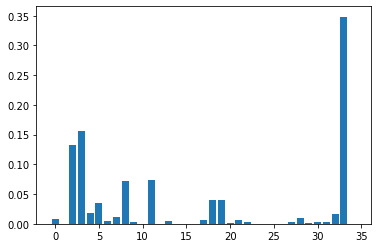

In [37]:
from matplotlib import pyplot
pyplot.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
pyplot.show()

<AxesSubplot:>

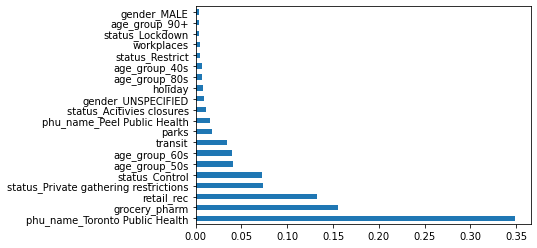

In [39]:
importance = pd.Series(classifier.feature_importances_, index=new_result.columns)
importance.nlargest(20).plot(kind='barh')